# Video Odometry

Kevin J. Walchko

Created: 15 Jan 2018

---

I grabbed the test video with my iPhone which saves it in `.mov` format. To convert it to a more portable `.mp4` that OpenCV can easily read, I used `ffmpeg` to convert it.

    ffmpeg -i vo.mov vo.mp4

The true movement of the camera was in an arc across the floor with it canted forward ~30 degrees.

iPhone 7 rear camera
- Resolution: 12MP
- Sensor: Sony Exmor RS (1.22 $\mu$m, 1/3")
- Focal Length: 28mm
- Max Aperture: f/1.8

## References

- [FAST Algorithm for Corner Detection](https://docs.opencv.org/3.4.0/df/d0c/tutorial_py_fast.html)
- [iPhone 7 specs](https://www.apple.com/iphone-7/specs/)
- [more camera specs](https://www.gsmarena.com/apple_iphone_7-8064.php)
- [Avi Singh, KS Venkatesh, *Monocular Visual Odometry*](monocular_vo.pdf)
- [J. Campbell, R. Sukthankar, I. Nourbakhsh, A. Pahwa, *A Robust Visual Odometry and Precipice Detection System Using Consumer-grade Monocular Vision*, Robotics and Automation, 2005. ICRA 2005. Proceedings of the 2005 IEEE International Conference, p. 3421 - 3427, 18-22 April 2005.](robust_vo.pdf)

![](vo_example.png)

Visual odometry is using a camera to figure out how far a robot has gone. It is very accurate when doing stereo vision because the system can determine how far points have travelled between frames. Monocular vision can be just as useful, except there is a scaling issue that needs to be determined (from another sensor) in order to determine the distance travelled. 

Why would you use video odometry (vo) instead of wheel encoders? Well, Mars rovers use it as they cross the shifting sands of Mars. Basically, anywhere you expect to wheel slip. Some good places are: sand dunes, uneven terain (jungles, disaster areas, etc), or ice/snow. Also, walking robots are good candidates for this.

### Process Overview

The basic idea of video odometry is:

- Grab image $I^t$
- Rectify image
- Use a feature detector like FAST to find features in $I^t$ and track those features in image $I^{t+1}$
    - Obviously, features will drop off the image as we move, so when the number of features becomes too small, we find new features to track.
    - In the code, a loss of one frame when the number of features becomes too small is assumed to not be critical to recovering the entire path
- Use RANSAC to calculate the essential matrix (E)
- Estimate R and t from E
- Concatinate the translations and rotation

### Equations

$$
s \circ (u, v, 1)^T = C \circ E \circ (x, y, z, 1)^T
$$

**(u, v):** Features detected in the image.

**(x,y,z):** Real world 3D position.

**Scale Factor (s):** Since we are trying to recover 3D information from a 2D image, we use a scale factor to help recover real world movement.

**Essential Matrix (E):** Contains the rotation and translation (R|t) of a second camera relative to the first camera in stereo vision.

**Fundamental Matrix (F):** Same as E, but with intrinsics. If the images are already rectified, then F = E.

**Camera Matrix (C):** The camera matrix contains both the focal lengths (x,y) and the center point (x,y) of the image for the camera. You can use the the camera matrix to move between 2D (in the image) and 3D (in the real world) points.


In the image above, the camera is angled such that it sees both sky and ground. The system is setup to only track objects on the ground. Instead of that setup, here the camera is canted so all it sees is ground. It will allow more image space to find and track features. However, more image space means more computational time ... it is a double edged sword. In order to recover the movement, we need to understand how pixels in the image are moving in
the real world.

<img src="vo_ref.png" width="50%">

$$
\tan(\alpha)= \frac{H}{D} \\
\tan(\beta)=(2 v - V) \tan( \frac{VFOV}{2}) \\
y = \frac{H}{\tan(\alpha + \beta)} \\
z = \frac{H \cos(\beta)}{\sin(\alpha + \beta)}
$$

where VFOV is the vertical field of view, v is the vertical location of the feature on the image plane, V is the vertical dimension of the image in pixels (e.g. 1920 rows).

In [9]:
%matplotlib inline 

In [10]:
from __future__ import print_function, division
import numpy as np
import cv2
import time
from matplotlib import pyplot as plt
from math import atan2, pi, sin, tan, atan, cos, asin

In [79]:
def plotAngles(angles):
    """
    Plot the angular change
    """
    saver = []
    savep = []
    saveh = []

    for r,p,h in angles:
        saver.append(r)
        savep.append(p)
        saveh.append(h)

    plt.subplot(3,1,1)
    plt.ylabel('roll')
    plt.grid(True)
    plt.plot(saver)
    plt.subplot(3,1,2)
    plt.ylabel('pitch')
    plt.grid(True)
    plt.plot(savep)
    plt.subplot(3,1,3)
    plt.ylabel('yaw')
    plt.grid(True)
    plt.plot(saveh)

In [80]:
def plotGroundPath(pts):
    """
    Plot the ground path (x,y) location of the movement
    """
    savex = []
    savey = []
    savez = []

    for x,y,z in pts:
        savex.append(x)
        savey.append(y)
        savez.append(z)
    
    plt.subplot(1,2,1)
    plt.plot(savey, savex)
    plt.grid(True)
    plt.title('x,y');

    plt.subplot(1,2,2)
    plt.plot(savey, label='y')
    plt.plot(savex, label='x')
    plt.grid(True)
    plt.legend()
    plt.xlabel('samples')

In [12]:
# Show the raw video
# Note the sloppy movement and total lack of consistent camera orientation :)
from IPython.display import HTML # need this for embedding a movie in an iframe
HTML('<iframe src="vo.mp4" width="640" height="360" frameborder="0" webkitallowfullscreen mozallowfullscreen allowfullscreen></iframe>')

In [13]:
# read in the video and store it for processing
video = cv2.VideoCapture("vo.mp4")
print(video.isOpened())
buffer = []
try:
    while True:
        ok, frame = video.read()
        if ok:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            buffer.append(frame.copy())
        else:
            print('All done, read {} images'.format(len(buffer)))
            
            print('Read in {} frames, each {}x{} pixles'.format(
                len(buffer),
                buffer[0].shape[0],
                buffer[0].shape[1]))
            break
except Exception as e:
    print('Oops ... something happened')
    print(e)
video.release()

True
All done, read 254 images
Read in 254 frames, each 1920x1080 pixles


In [81]:
# functions for drawing things on images
# def drawKeyPointTracks(frame, mask, p1, p0):
# #     print('p0:', p0.shape)
# #     print('p1:', p1.shape)
        
#     f = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
    
#     if not mask:
#         mask = np.zeros_like(f)
        
#     for i,(new,old) in enumerate(zip(p1,p0)):
# #         print(new, old)
#         a,b = new.ravel()
#         c,d = old.ravel()
#         mask = cv2.line(mask, (a,b),(c,d), color[i%100].tolist(), 2)
#         f = cv2.circle(f,(a,b),5,color[i%100].tolist(),-1)
        
# #     print('frame', frame.shape, frame.dtype)
# #     print('maks', mask.shape, mask.dtype)
#     img = cv2.add(f,mask)
#     return img

def drawKeyPoints(im,keypoints):
    # im2 = cv2.drawKeypoints(im,keypoints,im,color=(255,0,0))
    # cv2.imshow('keypoints',im2)
    im2 = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)
    for i in keypoints:
        cv2.circle(im2,(int(i[0][0]),int(i[0][1])),3,(0,255,0),-1)
    
    cv2.putText(im2,str(len(keypoints)),(50,250),
                cv2.FONT_HERSHEY_SIMPLEX,4,(255,0,0),2,cv2.LINE_AA)
    return im2

In [82]:
def map2D(v,u,zz):
    """
    Because the camera is canted downward, which gives 
    us more features to track, we have to adjust (mathematically)
    the movement of the pixels.
    
    See the discussion and diagram at the start of this
    """
    H = .11
    D = .2
    V = 1920 # vertical pixels
    VFOV = 75*pi/180
    aa = atan2(H,D)
    B = atan((2*v-V)*tan(VFOV/2))
    y = H/tan(aa+B)
    z = H*cos(B)/sin(aa+B)
    return (y,u,z)

In [83]:
def DCM2Eul(R):
    """
    Given a rotation matrix, return the roll, pitch and yaw angles in degrees
    """
    return (180/pi*atan2(R[1,2],R[2,2]), 180/pi*asin(-R[0,2]), 180/pi*atan2(R[0,2],R[0,0]))

In [94]:
# This is just a collection of different feature detectors
def FAST(im):
    fast = cv2.FastFeatureDetector_create()
    fast.setNonmaxSuppression(True)
    fast.setThreshold(5)  # 20
    # find and draw the keypoints
    keypoints = fast.detect(im)
    keypoints=np.array([[k.pt] for k in keypoints],dtype='f4')
    return keypoints

def ORB(im):
    # this seems to loose points quickly
    orb = cv2.ORB_create()
    keypoints = orb.detect(im,None)
    keypoints=np.array([[k.pt] for k in keypoints],dtype='f4')
    return keypoints

def ShiTomasi(im):
    # params for ShiTomasi corner detection
    feature_params = dict( maxCorners = 500,
        qualityLevel = 0.3,
        minDistance = 7,
        blockSize = 7 )
    keypoints = cv2.goodFeaturesToTrack(im, mask = None, **feature_params)
    return keypoints

def featureDetection(im, method=0):
    """
    This initializes the feature to track OR finds new features when the 
    current group of tracked features falls off the image plane (or said
    anther way, are no longer in the image).
    """
    keypoints = None
    if method == 0:
        keypoints = FAST(im)
    elif method == 1:
        keypoints = ORB(im)
    elif method == 2:
        keypoints = ShiTomasi(im)
    else:
        print('ERROR: no method selected for feature detection')

    return keypoints


def featureTrack(new_gray,old_gray,p0):
    """
    Given some initial feature (p0) find the new location of those 
    features in the new image. All images are grayscale.
    """
    # Parameters for lucas kanade optical flow
    lk_params = dict(
        winSize  = (10,10),
        maxLevel = 3,
        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
    )

    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, new_gray, p0, None, **lk_params)

    # good points have st==1, so weed out the bad
    new = p0[st==1]
    old = p1[st==1]
    
    p1 = np.array([[k] for k in new],dtype=np.float32)
    p0 = np.array([[k] for k in old],dtype=np.float32)

    return p0, p1

In [98]:
pp = (buffer[0].shape[1]//2, buffer[0].shape[0]//2)
focal = 200.0
print('----------------------------')
print(' Focal Length[pixels]:', focal)
print(' Principle Point:', pp)
print('----------------------------')

R_f = np.eye(3,3,dtype=np.float)
t_f = np.array([0,0,0],dtype=np.float)
R = R_f.copy()
t = np.array([0,0,0],dtype=np.float)
t_prev = t.copy()
dist = 0.0

min_pts = 200

old_im = buffer[0]
p0 = featureDetection(old_im)
# print(p0)
# print(">> Inital features found:", p0.shape[0])

draw_mask = None
color = np.random.randint(0,255,(100,3))

save_pts = []
save_angles = []
save_im = []
for count, im in enumerate(buffer[1:]):
        # p0 - old pts
        # p1 - new pts
        p0, p1 = featureTrack(im,old_im,p0)
        
        save_im.append(drawKeyPoints(im, p0))
#         save_im.append(drawKeyPointTracks(im, draw_mask, p1, p0))

        # not enough new points p1
        if p1.shape[0] < min_pts:
            p0 = featureDetection(im)
            old_im = im.copy()
            print('>> [{}] Not enough pts, p0 {} p1 {}'.format(
                count,
                p0.shape[0],
                p1.shape[0]
                )
            )
            continue

        # print('>> [{}] pts, p0 {} p1 {}'.format(count,p0.shape[0],p1.shape[0]))

        # since these are rectified images, fundatmental (F) = essential (E)
        # E, mask = cv2.findEssentialMat(p0,p1,focal,pp,cv2.FM_RANSAC)
        # retval, R, t, mask = cv2.recoverPose(E,p0,p1,R_f,t_f,focal,pp,mask)

        # since these are rectified images, fundatmental (F) = essential (E)
        E, mask = cv2.findEssentialMat(p0,p1,focal,pp,cv2.FM_RANSAC, 0.999, 1.0)
        retval, R, t, mask = cv2.recoverPose(E,p0,p1,R,t,focal,pp,mask)

        # Now update the previous frame and previous points
        old_im = im.copy()
        p0 = p1

        # honestly I have not done the calibration to figure out what this
        # should be. As long as the gross motion is what I expect, I am happy
        scale = 1.0

        tt = map2D(*t)
        t_f = t_f + scale*R_f.dot(tt)
        R_f = R.dot(R_f)
        
        save_pts.append(t_f)
        save_angles.append(DCM2Eul(R_f))

print('Done')

----------------------------
 Focal Length[pixels]: 200.0
 Principle Point: (540, 960)
----------------------------
>> [108] Not enough pts, p0 3220 p1 195
>> [152] Not enough pts, p0 3603 p1 197
Done


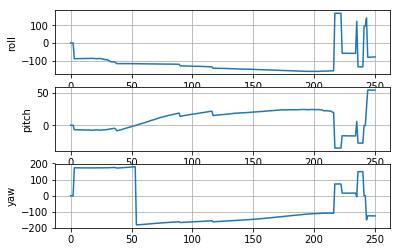

In [99]:
plotAngles(save_angles)

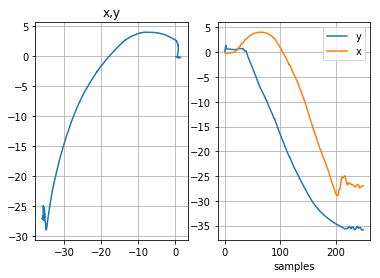

In [100]:
plotGroundPath(save_pts)

In [101]:
import platform
def videoWrite(frames, fname='out.mp4'):
    frame_height, frame_width, _ = frames[0].shape

    # pick a good encoder for the current OS
    sys = platform.system()
    if sys in ['Darwin']:  # this is on macOS
        fourcc = 'avc1'
    else:  # this is for Windoze
        fourcc = 'mjpg'

    out = cv2.VideoWriter(
        fname,
        cv2.VideoWriter_fourcc(*fourcc), 
        30, 
        (frame_width,frame_height))
    for frame in frames:
        out.write(frame)
    out.release()

In [102]:
# videoWrite(save_im, fname='interesting.mp4')

In [104]:
# HTML('<iframe src="interesting.mp4" width="640" height="360" frameborder="0" webkitallowfullscreen mozallowfullscreen allowfullscreen></iframe>')